In [1]:
#Import libraries
import nltk
import sklearn
import numpy as np
import pandas as pd
from sklearn import svm
from sklearn import metrics
from platform import python_version
from mlxtend.evaluate import confusion_matrix 
from sklearn.model_selection import GridSearchCV
from mlxtend.plotting import plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
%matplotlib inline

In [2]:
#Check Version of different libaries
print('The python version is {}'.format(python_version()))
print('The nltk version is {}.'.format(nltk.__version__))
print('The scikit-learn version is {}.'.format(sklearn.__version__))
print('The pandas version is {}.'.format(pd.__version__))
print('The numpy version is {}.'.format(np.__version__))

The python version is 3.6.5
The nltk version is 3.3.
The scikit-learn version is 0.20.1.
The pandas version is 0.23.0.
The numpy version is 1.16.2.


In [3]:
# Import dataset
df = pd.read_csv('D:/DataSet/machine_data.csv')
df = df[df.Machine==0]

In [4]:
#Visualizing first `5` rows
df.head()

,Machine,Date,Time,Cycle,Ob1,Ob2,Ob5,Ob7,Ob8,Ob9,...,Ob100,Ob101,Ob102,Ob103,Ob104,Ob105,Ob106,Ob107,Ob108,Class
0,0,20170101,3601,13,4415.22,770.79,176.77,9.46,15.08,1.27,...,40.32,0.36,1.60,45.0,40.00,55.84,42.24,17.48,80.46,1
10,0,20170101,3602,19,3990.14,771.84,296.46,9.20,12.30,3.33,...,39.57,0.57,1.62,45.0,39.28,54.78,40.81,17.06,78.97,1
20,0,20170101,3603,25,4641.26,758.63,-0.28,8.16,9.12,3.57,...,40.36,0.59,1.58,45.0,38.32,55.34,42.49,10.30,79.71,1
30,0,20170101,3604,31,3800.49,603.15,296.67,8.60,8.43,3.53,...,40.13,0.58,1.58,45.0,41.39,55.54,42.28,9.18,81.82,1
40,0,20170101,3605,19,4445.38,552.20,39.38,9.55,9.36,3.50,...,41.56,0.58,1.47,45.0,40.92,54.79,40.45,9.34,78.20,1


In [5]:
# Select normal and anomaly data as well as class
normal_data = df[df.Class == 0].iloc[:, 3: df.shape[1]-1].values
anomaly_data =  df[df.Class == 1].iloc[:, 3: df.shape[1]-1].values
normal_class = df.Class[df.Class == 0]
anomaly_class = df.Class[df.Class == 1]

In [6]:
#Split train(70%) test(30%) data(Normal)
from sklearn.model_selection import train_test_split  
X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(normal_data, normal_class, test_size = 0.3, shuffle = False ) 

#Split train(70%) test(30%) data(Anomaly)
from sklearn.model_selection import train_test_split  
X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(anomaly_data, anomaly_class, test_size = 0.3, shuffle = False)  

In [7]:
#Concat 70% normal and 70% anomaly train data
X_train=np.vstack((X_train_n, X_train_a))

#Concat 70% normal and 70% anomaly train target data
y_train=np.concatenate([y_train_n, y_train_a])

#Concat 30% normal and 30% anomaly test data
X_test=np.vstack((X_test_n, X_test_a))

#Concat 30% normal and 30% anomaly test target data
y_test=np.concatenate([y_test_n, y_test_a])

In [8]:
# Apply random under sampling for testing dataset
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(return_indices=True, random_state = 42)
X_train, y_train, idx_resampled = rus.fit_sample(X_train, y_train)

In [9]:
# Apply random under sampling for testing dataset
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(return_indices=True, random_state = 42)
X_test, y_test, idx_resampled = rus.fit_sample(X_test, y_test)

In [10]:
#Normalize the dataset
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
#Normalize test data
X_test = min_max_scaler.transform(X_test)

In [11]:
# Use a grid over parameters of interest
from sklearn.model_selection import GridSearchCV
classifier = RandomForestClassifier(n_jobs = -1, max_features = 'sqrt') 
param_grid = { 
           "n_estimators" : [9, 18, 27, 36, 45, 54, 63],
           "max_depth" : [1, 5, 10, 15, 20, 25, 30],
           "min_samples_leaf" : [1, 2, 4, 6, 8, 10]}

CV_rfc = GridSearchCV(estimator = classifier, param_grid = param_grid, cv = 10)
CV_rfc.fit(X_train, y_train)
best_param = CV_rfc.best_params_
#Get best paramers
print(CV_rfc.best_params_)

{'max_depth': 1, 'min_samples_leaf': 1, 'n_estimators': 9}


In [12]:
#Train the classifier
# Optimised with best parameter
classifier = RandomForestClassifier(max_depth = best_param.get('max_depth'), min_samples_leaf=  best_param.get('min_samples_leaf'), n_estimators = best_param.get('n_estimators'), random_state = 42)
classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=1, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=9, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [13]:
#Get prediction
y_pred = classifier.predict(X_test)

In [14]:
#Calculate accuracy
from sklearn import metrics
print("Accuracy %0.2f" % (100*metrics.accuracy_score(y_test, y_pred)))

Accuracy 74.83


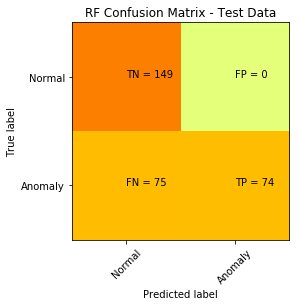

In [18]:
#Draw a confusion matrix
import matplotlib.pyplot as plt
from mlxtend.evaluate import confusion_matrix 
from mlxtend.plotting import plot_confusion_matrix

#Draw a confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Normal','Anomaly']
plt.title('RF Confusion Matrix - Test Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
 
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

In [16]:
#Get True Positive, True Negative, False Positive and False Negative Individually
TN = cm[0][0]
FN = cm[1][0]
TP = cm[1][1]
FP = cm[0][1]
#Calculate Detection Rate and False Alarm Rate
print("Detection Rate w.r.t anomaly class: ", (TP/(TP+FN)*100))
print("False positives rate w.r.t anomaly class: ", (FP/(FP+TN))*100)

Detection Rate w.r.t anomaly class:  49.664429530201346
False positives rate w.r.t anomaly class:  0.0


In [17]:
#Classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.67      1.00      0.80       149
           1       1.00      0.50      0.66       149

   micro avg       0.75      0.75      0.75       298
   macro avg       0.83      0.75      0.73       298
weighted avg       0.83      0.75      0.73       298

